<a href="https://colab.research.google.com/github/noramirabal/star_soccer_players/blob/main/star_soccer_player_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import files 
import io 
import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_score


%matplotlib inline

In [ ]:
uploaded = files.upload()
soccer = pd.read_csv(io.BytesIO(uploaded['soccer.csv']))

Saving soccer.csv to soccer.csv


In [ ]:
soccer

,Unnamed: 0,Name,Age,Over27,Nationality,Overall,Potential,Club,Value(M),Wage(K),Preferred Foot,Position,Height(in),Weight(lbs)
0,0,L. Messi,31,0,Argentina,94,94,FC Barcelona,110.5,565,0,A,68.40,159
1,1,Cristiano Ronaldo,33,0,Portugal,94,94,Juventus,77.0,405,1,A,74.40,183
2,2,Neymar Jr,26,1,Brazil,92,93,Paris Saint-Germain,118.5,290,1,A,70.80,150
3,3,De Gea,27,1,Spain,91,93,Manchester United,72.0,260,1,GK,76.80,168
4,4,K. De Bruyne,27,1,Belgium,91,92,Manchester City,102.0,355,1,M,61.32,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,987,B. Bourigeaud,24,1,France,77,81,Stade Rennais FC,11.5,28,1,M,68.40,150
988,988,R. Soriano,27,1,Italy,77,77,Torino,9.5,31,1,M,61.20,168
989,989,R. Sambueza,34,0,Argentina,77,77,Deportivo Toluca,4.5,26,0,M,72.00,159
990,990,Montoya,27,1,Spain,77,78,Brighton & Hove Albion,8.0,43,1,D,70.80,161


[(-0.0, 'Height(in)'), (-0.0, 'Weight(lbs)'), (8.905416404416119, 'Overall'), (0.5370837888970318, 'Potential'), (-3.0008036469253043, 'Age'), (3.8664417761133145, 'Wage(K)')]


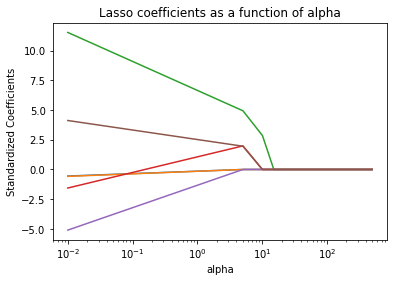

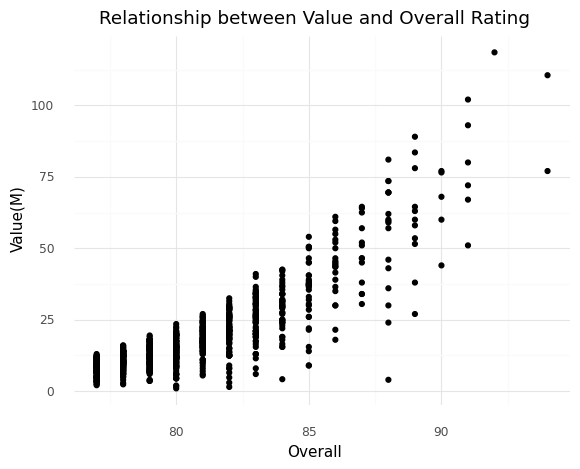

<ggplot: (8781583949817)>


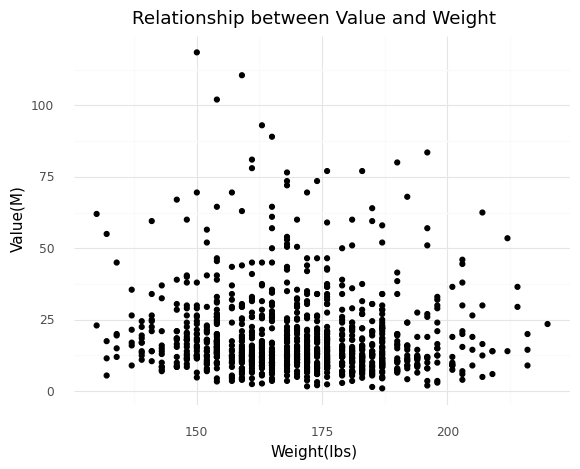

<ggplot: (8781582243629)>
TRAIN:  10.003590369071112
TEST :  9.374857896037565


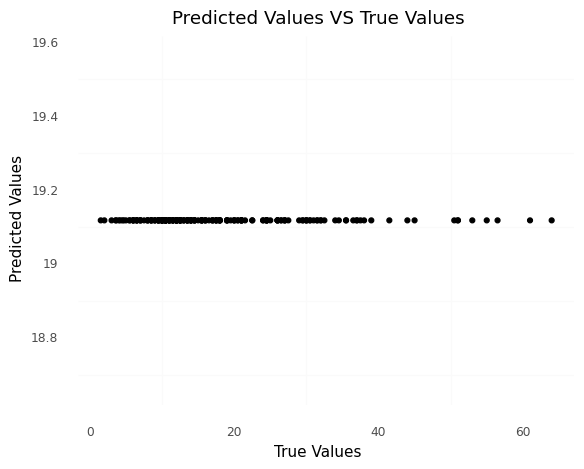

<ggplot: (8781582311713)>


In [ ]:
#Question 1: Linear Regression & PCA

feat = ['Height(in)', 'Weight(lbs)', 'Overall', 'Potential', 'Age','Wage(K)']
X = soccer[feat]
y = soccer['Value(M)']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

#zscoring
z = StandardScaler()

X_train[feat] = z.fit_transform(X_train[feat])
X_test[feat] = z.transform(X_test[feat])

#fitting a lasso mod with alpha of 1 & coefficients
lasso = Lasso()
lasso.fit(X_train, y_train)
Lasso(alpha=0)
print(list(zip(lasso.coef_, X)))

#alpha plot
alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

#Relationship Graphs
print(ggplot(soccer, aes(y = 'Value(M)', x = 'Overall')) +
      geom_point() + theme_minimal() + 
      ggtitle('Relationship between Value and Overall Rating'))

print(ggplot(soccer, aes(y = 'Value(M)', x = 'Weight(lbs)')) +
      geom_point() + theme_minimal() + 
      ggtitle('Relationship between Value and Weight'))

#MAE
print("TRAIN: ", mean_absolute_error(y_train, lasso.predict(X_train)))
print("TEST : ", mean_absolute_error(y_test, lasso.predict(X_test)))

y_pred = lasso.predict(X_test)

true_vs_pred = pd.DataFrame({'predict': y_pred, 'true': y_test})
true_vs_pred.head()

#predicted vs true graph
print(ggplot(true_vs_pred, aes(x = "true", y = 'predict')) + ggtitle('Predicted Values VS True Values') +
      geom_point() + theme_minimal() + labs(x = 'True Values', y = 'Predicted Values') +
      theme(panel_grid_major_x = element_blank(), panel_grid_major_y = element_blank()))






CHANGES:

I modified the question slightly from the one in the original analysis plan. There were some variables that I realized didn't have a strong relationship with a players Value and would have had too many factor groups to make our graphs look presentable and make it simpler for our audience of soccer team managers. Because of this I took out the variables preferred and club and added wage. Before I didn't originally plan to add wage but I realized it would make a lot of sense to add it into our model because it has a linear relationship with value and it was reflected in the coefficients later as I’ll explain more in detail. I used a function to find the lambda of best fit however it produced a really high lambda of 25 and when I used it all my variables were 0 as we would expect. Because of this I wanted to run the lasso model with a lambda value of 1.

ANSWER:

The variable that impacts a player's value the most is a player's overall rating. We can see this because our coefficient value is the highest for these variables which means it's the most significant and makes the greatest impact on the models predictions. The next two most significant coefficients are age and wage however they work inversely. While a higher wage means a higher value prediction, the older a player is the lower our value prediction for the players. Two of our variables shrunk completely to 0 which leads us to assume that they aren't significant in predicting value and those were height and weight. Potential rating wasn't completely shrunken to 0 however it was a very small value which means it's not as significant of a variable. In terms of answering our question the coefficient values are all we need however we need to also assess if our model is any good. Our MAE shows us that we can conclude that the model might be slightly overfit to our specific players in the data set because the train MAE is slightly less than our test MAE. Our mean absolute error in this context tells us that at any point our model is 9 million off of predicting someone's value (remember that our value is in terms of M or millions). This number is really high. We obviously don’t want to make any decisions as a soccer team manager based on a graph with this large of error. This was really confusing to me so I ran a predicted vs true value graph and I got my answer. My model was predicting the same exact value for every player which makes sense why our best alpha was so high, because in reality none of the coefficients have a meaningful impact on the value. The graphs I used consisted of a true v predicted plot, relationship graphs, and although not a ggplot graph I added a graph that shows us how lambda affects our coefficient values for different levels of penalization. I used the relationship graphs to enhance why we would suspect some of our specific variables to be minimized to 0 by lasso and some to be significant. For example we can see that the relationship between overall rating and value is very linear so we would predict a stronger coefficient value than we would for weight as we can see that weight actually doesn't have a linear relationship with value and is sporadic


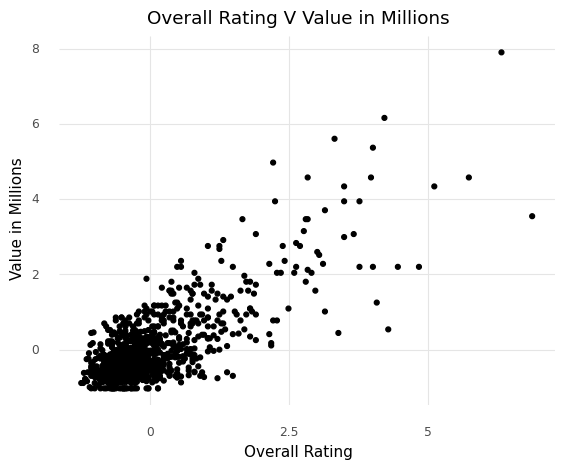

<ggplot: (8781571546121)>


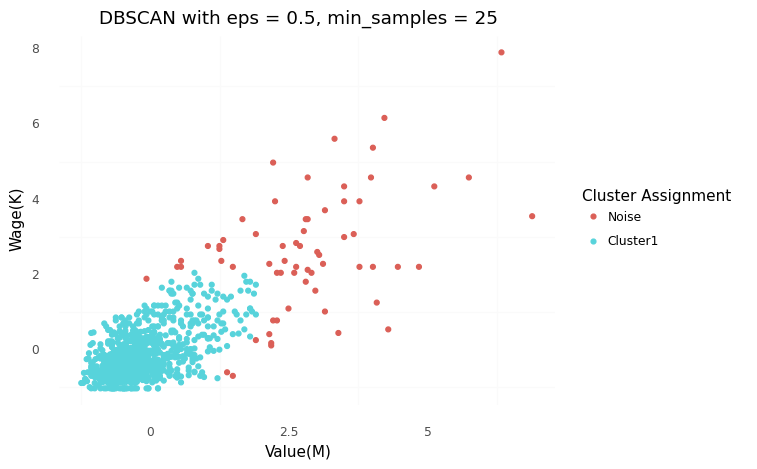

<ggplot: (8781582214673)>
0.7179296355294421


In [ ]:
#creating a new dataframe
df = soccer[['Value(M)','Wage(K)']].copy()

#Zscoring
z = StandardScaler()
df[['Value(M)','Wage(K)']] = z.fit_transform(df)

#relationship graph
print(ggplot(df, aes(x ='Value(M)', y = 'Wage(K)')) +geom_point() + theme_minimal() +
  theme(panel_grid_minor_x = element_blank(),
            panel_grid_minor_y = element_blank()) + 
 labs(x ='Overall Rating', y= 'Value in Millions') + 
 ggtitle('Overall Rating V Value in Millions'))

#dbscan
dbscan = DBSCAN(eps = 0.3, min_samples = 5).fit(df)

labsList = ['Noise']
labsList = labsList + ['Cluster' + str(i) for i in range(1,len(set(dbscan.labels_)))]

df["assignments"] = dbscan.labels_

#cluster graph
print(ggplot(df, aes(x = "Value(M)", y = "Wage(K)", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "DBSCAN with eps = 0.5, min_samples = 25"))

#silhouette score
print(silhouette_score(df[["Value(M)","Wage(K)"]], df["assignments"]))










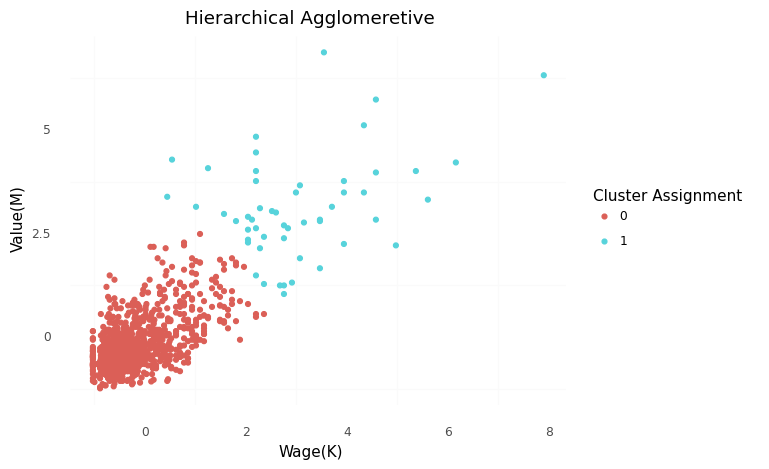

<ggplot: (8781570452673)>


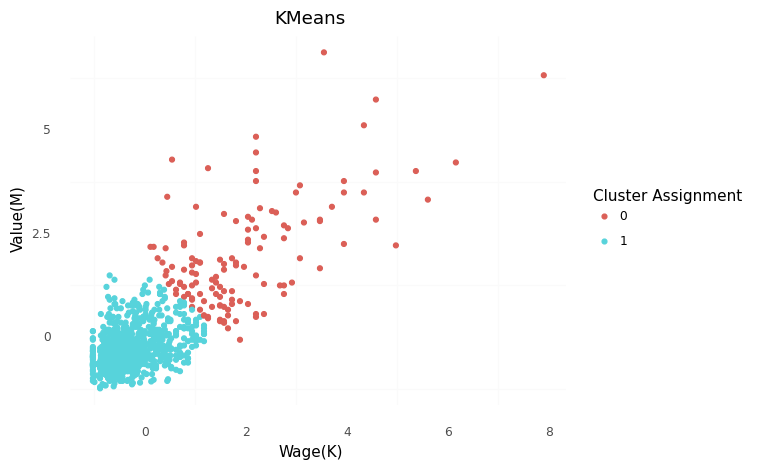

<ggplot: (8781571529989)>


In [ ]:
#different clustering algorthms to compare DBSCAN to
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

hac = AgglomerativeClustering(2)
km = KMeans(2)
gm = GaussianMixture(2)

hac.fit(df[["Wage(K)","Value(M)"]])
km.fit(df[["Wage(K)","Value(M)"]])
gm.fit(df[["Wage(K)","Value(M)"]])

df["hac"] = hac.labels_
df["km"] = km.labels_
df["gm"] = gm.predict(df[["Wage(K)","Value(M)"]])


print(ggplot(df, aes(x = "Wage(K)", y = "Value(M)",
                    color = "factor(hac)")) +
             geom_point() +
             theme_minimal() +
             scale_color_discrete(name = "Cluster Assignment") +
             theme(panel_grid_major = element_blank()) + 
             labs(title = "Hierarchical Agglomeretive"))

print(ggplot(df, aes(x = "Wage(K)", y = "Value(M)",
                    color = "factor(km)")) +
             geom_point() +
             theme_minimal() +
             scale_color_discrete(name = "Cluster Assignment") +
             theme(panel_grid_major = element_blank()) + 
             labs(title = "KMeans"))


































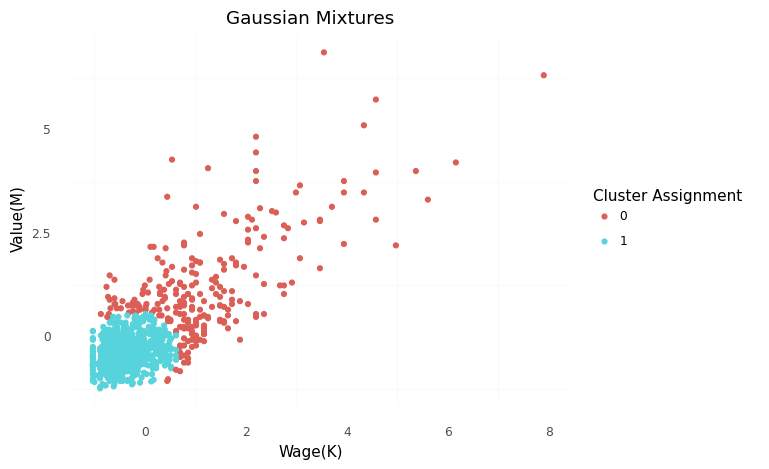

<ggplot: (8781571530157)>


In [ ]:
print(ggplot(df, aes(x = "Wage(K)", y = "Value(M)",
                    color = "factor(gm)")) +
             geom_point() +
             theme_minimal() +
             scale_color_discrete(name = "Cluster Assignment") +
             theme(panel_grid_major = element_blank()) + 
             labs(title = "Gaussian Mixtures"))


CHANGES:

I also made some changes to question 2 from the original analysis plan. Instead of adding the variable age to the clustering model I decided to run the other clustering algorithms we learned throughout the year to compare the outcomes. 

ANSWER:

I used DBSCAN because I didn't want to assume shapes and I wanted to take into account noise and as we can see from our results there is quite a bit of noise. To answer the question there is really only one group when we look at all the soccer players' value and wage, and its all the soccer players except for our superstars. This makes sense however because most players at a professional level although they're very good are very similar to each other, the players that we considered as noise were the superstar players which are very different from the average player cluster however also not very similar with the other superstar players. When we look at the other clustering algorithms we can see that they group the players pretty much the same as well. The biggest difference is that instead of classifying the superstar players as noise they are classified at another cluster which depending on what you're using the model to answer either clustering group is good. It is important to mention our silhouette score though because for our DBSCAN clustering group the score was around.71. This isn't an amazing score it tells us that our cluster is pretty similar to each other and pretty different from the noise but particularly completely separate. In order for a soccer team to run this algorithm I would probably make it a little better and maybe separate the players by position because if a team is trying to predict who their superstar players are and who their average players are we want a model with a bit higher of a silhouette score. 


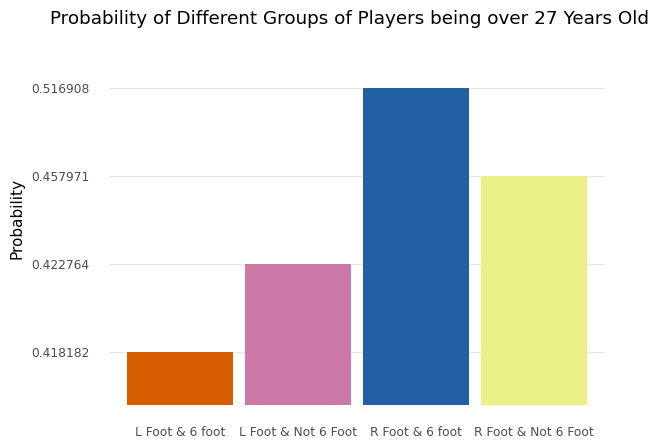

<ggplot: (8741927394973)>


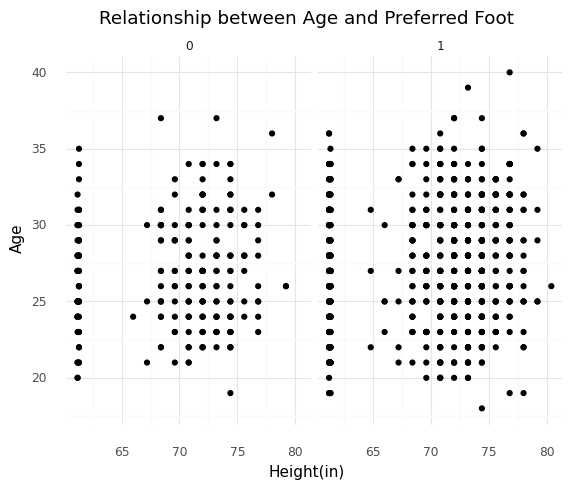

<ggplot: (8741927173025)>


In [ ]:
#Question 3: Probability

#adding a binomial variable for heigth if over 6 feet , no = 0
soccer['sixfeet'] = soccer['Height(in)'].apply(lambda x: 1 if x>=72 else 0)

#getting my probability
soccer.groupby(['Preferred Foot', 'sixfeet'])['Over27'].value_counts(normalize=True).reset_index(name='prob')
soccer.groupby(['Preferred Foot', 'sixfeet'])['Over27'].value_counts(normalize=True).reset_index(name='prob')

#creating a data frame with my probability and the new varibales
data1 = [['left_6', '0.418182' ], ['left_no', '0.422764' ],['right_6', "0.516908" ], ['right_no', '0.457971']]
probability = pd.DataFrame(data1, columns = ['predictor', 'probability'])

#graph
print(ggplot(probability, aes(y = 'probability', x = 'predictor', fill = 'predictor')) +
      geom_col() + theme_minimal() + scale_fill_manual(['#d55e00', '#cc79a7', '#235fa4', '#e8f086']) +
      theme(panel_grid_major_x = element_blank(), legend_position = 'none') + labs(y = 'Probability', x = '') +
      scale_x_discrete(labels =('L Foot & 6 foot','L Foot & Not 6 Foot','R Foot & 6 foot','R Foot & Not 6 Foot')) +
      ggtitle('Probability of Different Groups of Players being over 27 Years Old'))

print(ggplot(soccer, aes(y = 'Age', x = 'Height(in)')) +
      geom_point() + theme_minimal() + facet_wrap('Preferred Foot') +
      ggtitle('Relationship between Age and Preferred Foot'))


















































CHANGES:

none

ANSWER:

To answer the question there are different probabilities for each grouping of players as is reflected in the bar graph. The difference between these groups however is only 10% (from 41% to 51%. The probability of players that are left footed and above 6 feet tall being over 27 years old is around 41% while the probability for those who are right footed and under six feet tall it 46%. The other graph I added is the relationship between height and age and is separated for those who are left footed and those who are right footed. We can see that there is a similar pattern between both who are left and right footed so we can assume that it doesn't have any relationship with the rest of the variables. 
